<a href="https://colab.research.google.com/github/akankshakusf/Project-CNN-Deep-Learning-Malaria-Detection/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix,roc_curve

#import tensorflow packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,BatchNormalization, Input,InputLayer,Conv2D, MaxPool2D, Flatten,Dense,Dropout
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,FalseNegatives,FalsePositives,TruePositives,\
TrueNegatives,Precision,Recall,AUC

### What will we be carrying out?
- By this we can conclude that we can mix up models:
    *  First we built Sequential model
    *  Then we built Functional API Model which we broke down in feature_extractor_model which extracts features  and lenet_model_func where we flatten our features for final compiling and training
    * Then I built complete model LenetModel mixing up Functional API Model's feature_extractor
    * Ather that I go on to create a Custom dense layer NeuralearnDense

# **Data Preparation**

## Data Loading

In [2]:
# Import the Malaria dataset from TensorFlow Datasets (TFDS)
# and shuffle files
# Setting as_supervised=True returns the data as (image, label) pairs and not dict

dataset, dataset_info = tfds.load("malaria", with_info=True,as_supervised=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.KELBDZ_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


Scenario: lets say you dnt pull the data out from tensorflow instead you are pull it from you .text file. below is the approuch we will take

In [3]:
#function to split train data

def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    # Get dataset size
    DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()

    # Make train, val, test split
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))  # Skip train data
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))  # skip Remaining data as test

    return train_dataset, val_dataset, test_dataset

In [58]:
###### split function logic explaination builder ######

# TRAIN_RATIO=0.6
# VAL_RATIO=0.2
# TEST_RATIO=0.2
# TOTAL=10
# #set range on data for testing logic
# ds=tf.data.Dataset.range(TOTAL)
# #train_sd,val_ds,test_ds=split(ds,TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# train_ds=ds.take(int(TRAIN_RATIO*TOTAL))
# val_test_ds=ds.skip(int(TRAIN_RATIO*TOTAL)) #not important
# val_ds=val_test_ds.take(int(VAL_RATIO*TOTAL))
# test_ds=val_test_ds.skip(int(VAL_RATIO*TOTAL))

# #print main dataset for review
# print([int(x) for x in ds.as_numpy_iterator()])
# print([int(x) for x in train_ds.as_numpy_iterator()])
# print([int(x) for x in val_test_ds.as_numpy_iterator()])
# print([int(x) for x in val_ds.as_numpy_iterator()])
# print([int(x) for x in test_ds.as_numpy_iterator()])


In [4]:
# Shuffle dataset before splitting
dataset = dataset["train"].shuffle(buffer_size=10000, reshuffle_each_iteration=False)

In [5]:
# Define split ratios
# split it into three parts:
# - The first 80% of the data will be used for training.
# - The next 10% (80%-90%) will be used for validation
# - The last 10% (90%-100%) will be used for testing.
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Call split function
train_dataset, val_dataset, test_dataset = split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [6]:
# Check dataset sizes
print(f"Training size: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training size: 22046
Validation size: 2755
Test size: 2757


In [7]:
#check data info
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

So, in the data 0 represent parasitic
and 1 represents uneffected

In [8]:
#check to values in dataset_info
print(dataset_info.features['label'].int2str(0))
print(dataset_info.features['label'].int2str(1))

parasitized
uninfected


In [9]:
# Print a few values from the validation dataset
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(112, 124, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


## Dataset Visualization

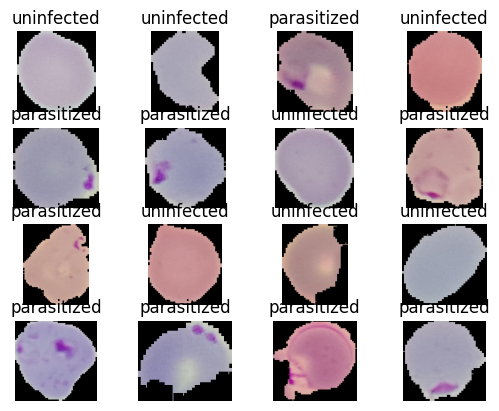

In [10]:
for i, (image, label) in enumerate(train_dataset.take(16)):  #Unpack tuple
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy())  # Convert Tensor to NumPy array
    plt.title(dataset_info.features['label'].int2str(label.numpy()))  # Convert label to class name
    plt.axis("off")

plt.show()

## Data Augmentation (Only Resizing technique)

- These images are of bigger sizes (255,255,3) etc. But we will have to Normalize them and bring them in the range of 0-1 so Deep learningn model converges or inference faster

In [ ]:
#define the image size we want to reduce to
IM_SIZE=224
BATCH_SIZE=32

def resize_rescale(image, label):
    # Resize and rescale the image
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    return image, label

# Apply the function to the dataset
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
###----- This is for testing batches as they give problems later in tensor to array conversion-----###

# Count the total number of images in the train, val, and test datasets
train_images = sum(1 for _ in train_dataset.unbatch())
val_images = sum(1 for _ in val_dataset.unbatch())
test_images = sum(1 for _ in test_dataset.unbatch())

print(f"Total images in train dataset: {train_images}")
print(f"Total images in validation dataset: {val_images}")
print(f"Total images in test dataset: {test_images}")

print("----------------------------------------------------------")
# Calculate the number of batches
train_batches = train_images // BATCH_SIZE
val_batches = val_images // BATCH_SIZE
test_batches = test_images // BATCH_SIZE

print(f"Number of batches in train dataset: {train_batches}")
print(f"Number of batches in validation dataset: {val_batches}")
print(f"Number of batches in test dataset: {test_batches}")  # after 2 full batches of 32, 3rd batch has only 23 images left.

Total images in train dataset: 22046
Total images in validation dataset: 2755
Total images in test dataset: 2757
----------------------------------------------------------
Number of batches in train dataset: 688
Number of batches in validation dataset: 86
Number of batches in test dataset: 86


* Uncomment and run this to check batch that fail to meet shape criteria

In [ ]:
# def get_last_batch_info(total_images, batch_size):
#     # Calculate number of full batches
#     full_batches = total_images // batch_size

#     # Calculate the number of images in the last batch
#     last_batch_size = total_images % batch_size

#     # If there are no remainder images, last batch size will be the same as batch size
#     if last_batch_size == 0:
#         last_batch_size = batch_size  # The last batch will be of full size

#     # Calculate the total number of batches
#     total_batches = full_batches if last_batch_size == batch_size else full_batches + 1

#     # Print the results
#     print(f"Total images: {total_images}")
#     print(f"Batch size: {batch_size}")
#     print(f"Number of full batches: {full_batches}")
#     print(f"Total number of batches: {total_batches}")
#     print(f"Size of the last batch: {last_batch_size}")

#     return last_batch_size

# get_last_batch_info(2757,32)

In [ ]:
#view for verification
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (32, 224, 224, 3)
Label: tf.Tensor([1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0], shape=(32,), dtype=int64)


In [ ]:
#view for verification
for image, label in test_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (32, 224, 224, 3)
Label: tf.Tensor([1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1], shape=(32,), dtype=int64)


* see that image size is now 224 : of shape shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)
- tf.Tensor(1, meaning its was not infected cell

In [ ]:
#check for unique values in transformed train_dataset
np.set_printoptions(suppress=True, precision=6)
np.unique(image)

array([0.      , 0.000028, 0.000029, ..., 0.934856, 0.938866, 0.942314],
      dtype=float32)

* Notice - here  goal is achieved of having all values in between 0 to 1

# **Data Preprocessing** (Advanced)

### Data Augmentation (Advanced)

In [11]:
#define the image size we want to reduce to
IM_SIZE=224
BATCH_SIZE=32

##create resize_rescale fucntion
def resize_rescale(image, label):
    # Resize and rescale the image
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    return image, label

In [12]:
## create augmenting fucntion
def augment(image,label):

  #call resize_rescale function above to get image and label
  image,label=resize_rescale(image,label)

  # I will be using rot90,adjust_saturation and flip_left_right augmentation
  image =tf.image.rot90(image)
  image= tf.image.adjust_saturation(image, saturation_factor=0.3)
  image=tf.image.flip_left_right(image)

  return image,label

In [14]:
# Apply augment function to the dataset and reshuffle
train_dataset = (train_dataset
                .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                .map(augment)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE)
)

# we do not augment val_dataset just resize_rescale
val_dataset = (val_dataset
               .shuffle(buffer_size=8, reshuffle_each_iteration=True)
               .map(resize_rescale)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

# we do not augment test_dataset just resize_rescale
test_dataset = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [71]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

* Batching with different Augmentation techniques

In [72]:
def visualize(original,augmented):
  # original image is a batch of 32 images
  # take the first image from the batch for visualization

  original = original[0]
  augmented = augmented[0]

  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.label

  plt.subplot(1,2,2)
  plt.imshow(augmented)


In [73]:
original_image, label= next(iter(train_dataset))

* there are several methods used to Augment the data we will be using adjust_saturation
-adjust_brightness(...): Adjust the brightness of RGB or Grayscale images.
-adjust_saturation(...): Adjust saturation of RGB images.
-central_crop(...): Crop the central region of the image(s).
-crop_and_resize(...): Extracts crops from the input image tensor and resizes them.
-flip_left_right(...): Flip an image horizontally (left to right).
-etc


In [74]:
#I will be using adjust_saturation
augmented_image=tf.image.adjust_saturation(original_image, saturation_factor=0.3)

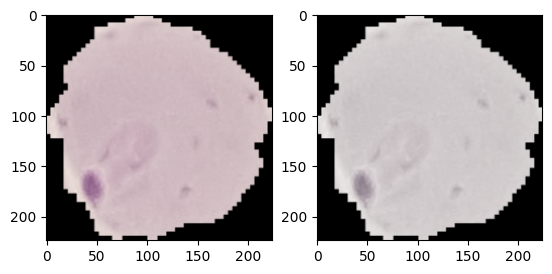

In [75]:
#call the visualize fucntion
visualize(original_image,augmented_image)

The sequential model performed very poorly with the this. Reason being simple that if I go back and see my augmentation I have used "tf.image.adjust_saturation(image, saturation_factor=0.3)" with the implementation of this

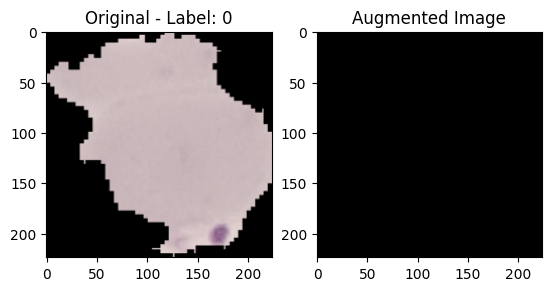

In [87]:
# ## This is a testing cell
# def visualize(original, augmented, original_labels):

#   original_image = original[0]
#   augmented_image = augmented[0]
#   original_label = original_labels[0].numpy()  # Get the label as a NumPy value

#   plt.subplot(1, 2, 1)
#   plt.imshow(original_image)
#   plt.title(f"Original - Label: {original_label}")  # Display label in title

#   plt.subplot(1, 2, 2)
#   plt.imshow(augmented_image)
#   plt.title("Augmented Image")  # Title for augmented image


# for original_images, original_labels in train_dataset.take(1):  # Take 1 batch from the dataset
#     augmented_images, augmented_labels = augment(original_images, original_labels)  # Apply augmentations

#     # Now you can call the visualize function with the images and labels
#     visualize(original_images, augmented_images, original_labels)  # Include original_labels


### Data Loading (Advanced)

### Mixup Data Augmentation

### CutMix Data *Augmentation*

### Albumentations

### Repeating the dataset (x5)

# **Building advanced Models with Functional API, Subclassing and Custom Layers  using Keras API**

## Basic: Sequential API:LeNet Model

- This exact model summary is explained with full walk through in notion https://www.notion.so/CNN-Layering-Neuron-Count-1bc4ba18200f80ffa385ea743e4a30cd

In [76]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()

In [77]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''
IM_SIZE=224
dropout_rate=0.2
regularization_rate=0.01

lenet_model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps
    Dropout(rate=dropout_rate),   #add a dropout layer

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu",kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again


    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(100, activation="relu",kernel_regularizer=L2(regularization_rate)),  # Fully connected layer
    BatchNormalization(),
    Dropout(rate=dropout_rate),   #add a dropout layer

    Dense(10, activation="relu",kernel_regularizer=L2(regularization_rate)),   # Further processing
    BatchNormalization(),

    Dense(1, activation="sigmoid"),     # Output layer (binary classification)

])

# Print model summary
lenet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

Building more advanced Models with Functional API,
Subclassing and Custom Layers

## Functional API :LeNet Model

In [ ]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()

In [ ]:
'''
1.a.Feature Extractor Model "NON Sequential"
'''
#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)
x= BatchNormalization()(x)
x= MaxPool2D(pool_size=2, strides=2)(x)  # Downsamples feature maps

# 2nd conv layer (extracts deeper features)
x= Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x= BatchNormalization()(x)
output= MaxPool2D(pool_size=2, strides=2)(x)  # Downsampling again

#create lenet model
feature_extractor_model = Model(func_input,output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
'''
1.b.Feature Extractor with "Sequential Model"
'''
feature_extractor_seq_model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again


])

# Print model summary
feature_extractor_seq_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

## Callable Model

In [ ]:
'''
2. Flatten and instantiate the CNN model with above Sequential or Non Sequential model
'''
#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= feature_extractor_seq_model(func_input)

x= Flatten()(x) # Converts 2D feature maps into 1D array

x= Dense(100, activation="relu")(x)  # Fully connected layer
x= BatchNormalization()(x)

x= Dense(10, activation="relu")(x)   # Further processing
x= BatchNormalization()(x)

func_output= Dense(1, activation="sigmoid")(x)     # Output layer (binary classification)

#create lenet model
lenet_model_func = Model(func_input,func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

## Model Subclassing:LeNet Model

In [ ]:
'''
1. making a class for feature extraction which will have subclass that inherits from "Layer" class
'''
class FeatureExtractor(Layer):
  #create init Method
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor,self).__init__()
    self.conv_1  = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation) # 1st conv layer (extracts basic patterns)
    self.batch_1 = BatchNormalization()
    self.pool_1  = MaxPool2D(pool_size=pool_size, strides=2*strides) # Downsamples feature maps


    self.conv_2  = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation) # 2nd conv layer (extracts deeper features)
    self.batch_2 = BatchNormalization()
    self.pool_2  = MaxPool2D(pool_size=pool_size, strides=2*strides) # Downsampling again

  #create Call Method
  def call(self,x,training):

    x=self.conv_1(x)
    x = self.batch_1(x, training=training)
    x=self.pool_1(x)

    x=self.conv_2(x)
    x = self.batch_2(x, training=training)
    x=self.pool_2(x)

    return x

feature_sub_classed=FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
'''
2.Flatten and instantiate the CNN model with Subclassing above
'''
#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= feature_sub_classed(func_input,training=True)

x= Flatten()(x) # Converts 2D feature maps into 1D array

x= Dense(100, activation="relu")(x)  # Fully connected layer
x= BatchNormalization()(x)

x= Dense(10, activation="relu")(x)   # Further processing
x= BatchNormalization()(x)

func_output= Dense(1, activation="sigmoid")(x)     # Output layer (binary classification)

#create lenet model
lenet_model_func = Model(func_input,func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
'''
1.making a new model with above FeatureExtractor method for the extracting patterns
'''
class LenetModel(Model):
  #create init Method
  def __init__(self):
    super(LenetModel,self).__init__()

    self.feature_extractor  = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten() # Converts 2D feature maps into 1D array

    self.dense_1=Dense(100, activation="relu") # Fully connected layer
    self.batch_1=BatchNormalization()

    self.dense_2=Dense(10, activation="relu") # Further processing
    self.batch_2=BatchNormalization()

    self.dense_3=Dense(1, activation="sigmoid")


  #create Call Method
  def call(self,x,training=False):

    x=self.feature_extractor(x, training=training)
    x=self.flatten(x)
    x=self.dense_1(x)
    x=self.batch_1(x,training=training)
    x=self.dense_2(x)
    x=self.batch_2(x, training=training)
    x=self.dense_3(x)
    return x

#instantiate the model:
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

## Custom Dense Layers

*  I create built this  method from this page :https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing
* I also used - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
* refer random_initializer = https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal

**Explaination of Dense Layer**

Dense Layer in Simple Terms:A dense layer in a neural network works by multiplying the inputs (features) by weights
and then adding a bias. This can be written as:
---> = mx + c
Where:
    m = weights
    x = input features
    c = bias

Shapes of Matrices:
- Input matrix has a shape of (b, f):
    - b is the batch size (number of examples),
    - f is the number of features (input size).
  
- Weights matrix has a shape of (f, o):
    - f matches the input features,
    - o is the output size (number of neurons in the layer).
    
So, understand here the shape should match meaning columns for 1 matrix (b,f)
   should have same shape as rows of 2nd matrix(w,b)

TensorFlow's Role:
TensorFlow ensures that the number of features in the input matches the number of weights,
so the multiplication works. If they don’t match, TensorFlow automatically adjusts the shapes
to prevent errors.

Finally, the bias is added to the result, and that's how the dense layer produces an output.


In [ ]:
# class Linear(keras.layers.Layer):
#     def __init__(self, units=32, input_dim=32):
#         super().__init__()
#         self.w = self.add_weight(
#             shape=(input_dim, units), initializer="random_normal", trainable=True
#         )
#         self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

#     def call(self, inputs):
#         return tf.matmul(inputs, self.w) + self.b

In [ ]:
'''
1. Making Custom Dense Layer
'''

class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units
    self.activation = activation


  def build(self,input_features_shape):
    # w stands for weights
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units),initializer="random_normal",trainable=True)
    # b stands for biases
    self.b = self.add_weight(shape=(self.output_units,),initializer="random_normal",trainable=True)


  def call(self, input_features):
    pre_output= tf.matmul(input_features,self.w) + self.b # w stands for weights , b for biases

    if (self.activation =="relu"):
      return tf.nn.relu(pre_output)

    elif (self.activation=="sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [ ]:
'''
2.using my NeuralearnDense layer for the extracting patterns
'''
IM_SIZE = 224
# Instantiate the CNN model
lenet_custom_model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again

    Flatten(),  # Converts 2D feature maps into 1D array

    NeuralearnDense(100, activation="relu"),  # Fully connected layer
    BatchNormalization(),

    NeuralearnDense(10, activation="relu"),   # Further processing
    BatchNormalization(),

    NeuralearnDense(1, activation="sigmoid"),     # Output layer (binary classification)

])

# Print model summary
lenet_custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense (NeuralearnDense)   │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_1 (NeuralearnDense) │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_2 (NeuralearnDense) │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

# Callbacks : Different Types

- i have referred this : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
- This too:https://github.com/keras-team/keras/blob/v3.3.3/keras/src/callbacks/callback.py#L106-L119


## Custom Callback

In [ ]:
# Define a custom callback class to monitor the model's loss during training
class LossCallback(Callback):

  #call this method at the end of each training epoch
  def on_epoch_end(self, epoch, logs):
    # Print the loss value
    print("\nFor the Epoch Number {} the model has a loss of {:.5f}".format(epoch+1, logs["loss"]))

  #call this method at the end of each training epoch
  def on_batch_end(self,batch,logs):
    print("\nFor the Batch Number {} the model has a loss of {:.5f}".format(batch+1, logs["loss"]))


## CSVLogger

In [ ]:
csv_callback=CSVLogger(
    filename='logs.csv', separator=',', append=False
)

## EarlyStopping

In [ ]:
# Create an instance of EarlyStoppping Callback
earlystopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
earlystopping_callback

## LearningRateScheduler
* i referred this - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr *float(tf.math.exp(-0.1))

#initialize the scheduler and call the function
scheduler_callback=LearningRateScheduler(scheduler,verbose=1)

## ModelCheckpoint

In [ ]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq= 3 #epoch
)

## ReduceLROnPlateau

In [78]:
plateau_callback=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=0
)

# Model Compiling and Training

In [79]:
metrics=[TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),
         BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [80]:
# Compile the model
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),  # Optimizer: Adam with learning rate 0.01
    loss=BinaryCrossentropy(),  # Loss function: Binary Crossentropy for binary classification
    metrics=metrics  # Metrics: Binary Accuracy
)

In [81]:
#fit the model
history =lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=True,
    callbacks=[plateau_callback]
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.5872 - auc: 0.6173 - fn: 2190.4624 - fp: 2291.6536 - loss: 8.2675 - precision: 0.5852 - recall: 0.5870 - tn: 3237.4624 - tp: 3336.3696 - val_accuracy: 0.5245 - val_auc: 0.6486 - val_fn: 52.0000 - val_fp: 1258.0000 - val_loss: 2.0906 - val_precision: 0.5141 - val_recall: 0.9624 - val_tn: 114.0000 - val_tp: 1331.0000 - learning_rate: 0.0100
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7644 - auc: 0.8280 - fn: 991.0913 - fp: 1273.6116 - loss: 3.1980 - precision: 0.7563 - recall: 0.7742 - tn: 4250.9219 - tp: 4540.3232 - val_accuracy: 0.6784 - val_auc: 0.7076 - val_fn: 343.0000 - val_fp: 543.0000 - val_loss: 3.3871 - val_precision: 0.6458 - val_recall: 0.7427 - val_tn: 879.0000 - val_tp: 990.0000 - learning_rate: 0.0100
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8593 - auc: 0.9048 - fn: 489.0681 - fp: 924.1681 - loss: 2.7844 - precision: 0.8326 - recall: 0.8956 - tn: 4604.0723 - 

# Visualizations

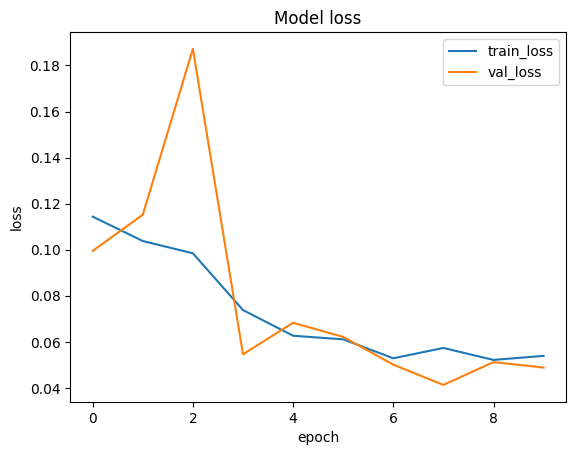

In [ ]:
#plot the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

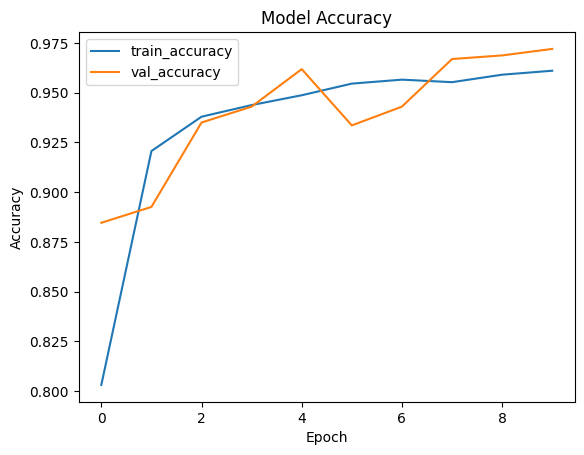

In [ ]:
#plot the accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Visualizing Confusion Matrix

* ATTENTION : As we know Number of batches in test dataset: 86, And the last batch has

In [ ]:
inputs = []
labels = []

# Iterate through the batched dataset
for x, y in test_dataset.as_numpy_iterator():
    inputs.append(x)  # Collect images
    labels.append(y)  # Collect labels

# Concatenate and Flatten the list of batches into a single array
inputs = np.concatenate(inputs, axis=0)
labels = np.concatenate(labels, axis=0)

Shape of inputs: (2757, 224, 224, 3)
Shape of labels: (2757,)


In [ ]:
inputs.shape

(2757, 224, 224, 3)

In [ ]:
labels.shape

(2757,)

In [ ]:
#make the predictions
predicted=lenet_model.predict(inputs)
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[0.011765 0.00364  0.045455 ... 0.999731 0.011546 0.99973 ]


[[1299   81]
 [  91 1286]]


Text(0.5, 14.722222222222216, 'Predicted')

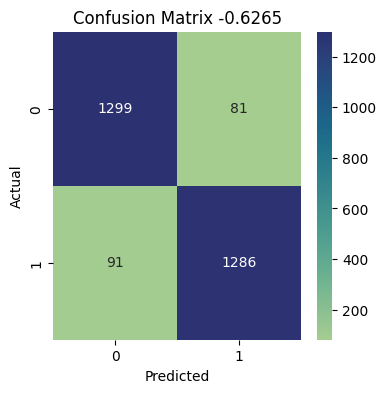

In [ ]:
#plot confusion matrix
threshold=0.6265

plt.figure(figsize=(4,4))
cm=confusion_matrix(labels,predicted>threshold)
print(cm)

sns.heatmap(cm,annot=True, fmt='g',cmap="crest")
plt.title("Confusion Matrix -{}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")


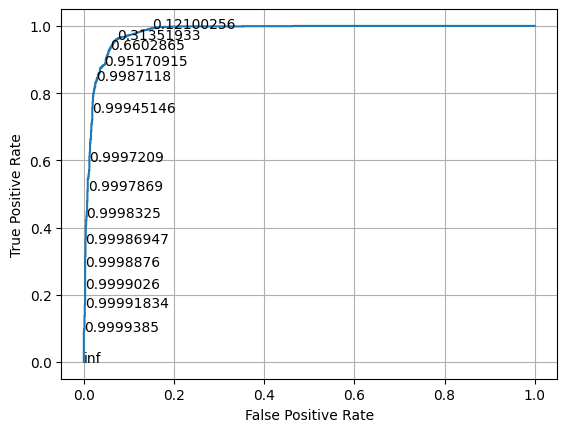

In [ ]:
# Calculate FPR, TPR, and threshold values for ROC curve
fp, tp, threshold = roc_curve(labels, predicted)

# Plot ROC curve with FPR on x-axis and TPR on y-axis
plt.plot(fp, tp)

# Label axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Show grid
plt.grid()

# Skip some thresholds for cleaner labels
skip =30

# Annotate ROC curve with threshold values
for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], threshold[i])

# Display the plot
plt.show()


# **Model Evaluation and Testing**

In [ ]:
#evaluate model
lenet_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9376 - auc: 0.9711 - fn: 42.2727 - fp: 48.1136 - loss: 0.2643 - precision: 0.9305 - recall: 0.9427 - tn: 680.3068 - tp: 652.3295


[0.2441781908273697,
 1273.0,
 89.0,
 1317.0,
 78.0,
 0.9394268989562988,
 0.9346548914909363,
 0.942264974117279,
 0.9737226963043213]

- The losses are less and accuracy is good

In [ ]:
#testing model
def parasite_or_not(x):
  if x>0.5:
    return str("P")
  else:
    return str("U")

- model predictions
- test_dataset.take(1) retrieves one batch from the dataset, but it remains a Dataset object.
- model.predict() expects a NumPy array or Tensor, so test_dataset.take(1) must be properly extracted first.

- [0] extracts the first batch of predictions.
- [0] extracts the first image's prediction score (since it's a binary classification problem, the output is a single probability value).

In [ ]:
#make predictions
print(parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


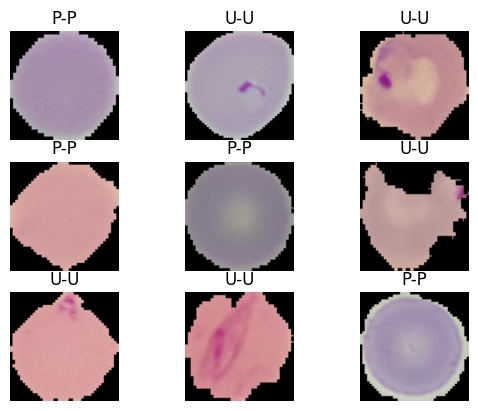

In [ ]:
#Visualize the predictions
for image.label in test_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    #first display what label model predicted and then show its corresponding image
    plt.title(parasite_or_not(label.numpy()[i])+ "-"+ parasite_or_not(lenet_model.predict(image)[i][0]))
    plt.axis("off")
plt.show()


# Loading and Saving model

In [ ]:
#using .keras to save
lenet_model.save("/content/lenet_malaria_detection.keras")

In [ ]:
from tensorflow.keras.models import load_model
# Load the saved model
lenet_loaded_model = load_model("lenet_malaria_detection.keras")
# Check the model architecture
lenet_loaded_model.summary()

# Check if weights are loaded
print("Loaded Model Weights:", len(lenet_loaded_model.weights))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)

Loaded Model Weights: 26


IT WAS THIS BEFORE SAVING :
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9634 - loss: 0.1453
[0.41822549700737, 0.9651795625686646

In [ ]:
# evaluate the performance of loaded model
# it should be similar as before

#evaluate model
lenet_loaded_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9623 - loss: 0.1174


[0.12207277119159698, 0.9601015448570251]

# Saving to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/